In [5]:
# First lets improve libraries that we are going to be used in this lab session
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import csv
import pandas as pd
import spacy
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pickle
import matplotlib.pyplot as plt
random.seed(134)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

In [97]:
filepath = './hw2_data'
snli_train_path = filepath + "/snli_train.tsv"
snli_val_path = filepath + "/snli_val.tsv"
train_df = pd.read_csv(snli_train_path, sep='\t', header=0)

In [ ]:
train_df.head()

# Build pretrained embedding word matrix of FastText

In [ ]:
# load FastText
ft_home = './'
words_to_load = 50000

with open(ft_home + 'wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft = np.zeros((words_to_load+2, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    ordered_words_ft.extend(['<pad>', '<unk>'])
    loaded_embeddings_ft[0,:] = np.zeros(300)
    loaded_embeddings_ft[1,:] = np.random.normal(size=300)
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i+2, :] = np.asarray(s[1:])
        words_ft[s[0]] = i+2
        idx2words_ft[i+2] = s[0]
        ordered_words_ft.append(s[0])
    words_ft['<pad>'] = 0
    words_ft['<unk>'] = 1

In [ ]:
pickle.dump(loaded_embeddings_ft, open('wiki-news-300d-50k.pkl', 'wb'))
pickle.dump(words_ft, open('word2idex_50k.pkl', 'wb'))
pickle.dump(ordered_words_ft, open('ordered_words_ft-50k.pkl', 'wb'))

In [29]:
loaded_embeddings_ft = pkl.load(open('wiki-news-300d-50k.pkl', "rb"))
words_ft = pkl.load(open('word2idex_50k.pkl', "rb"))
ordered_words_ft = pkl.load(open('ordered_words_ft-50k.pkl', "rb"))

# One hot encode tokens of train&val dataset according FastText words

In [98]:
### Function that preprocessed dataset
def read_data(datapath):
    df =  pd.read_csv(datapath, sep='\t', header=0)
    dataset = []
    length = []
    
    for index, row in df.iterrows():
        if row['label'] == 'entailment':
            label = 0
        elif row['label'] == 'contradiction':
            label = 1
        else:
            label = 2
        dataset.append(([token for token in row['sentence1'].split()], 
                        [token for token in row['sentence2'].split()], 
                        label))    
        length.append(max(len(row['sentence1'].split()),len(row['sentence2'].split())))
    max_len = max(length)    
    return dataset, max_len,length

In [99]:
train_data_tokens, MAX_Sentence_LENGTH, length= read_data(snli_train_path)
val_data_tokens, _ , _= read_data(snli_val_path)

In [ ]:
print(MAX_Sentence_LENGTH)
print(np.percentile(length, 98))
plt.hist(length, bins=1000)
plt.ylabel('length');
plt.show()

In [42]:
# according the plot above, unify sentence length as 40
MAX_Sentence_LENGTH = 30

In [100]:
# convert token to idx in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        sentence1_index_list = [words_ft[token] if token in ordered_words_ft else UNK_IDX for token in tokens[0]]
        sentence2_index_list = [words_ft[token] if token in ordered_words_ft else UNK_IDX for token in tokens[1]]       
        indices_data.append((sentence1_index_list, sentence2_index_list, tokens[2]))
    return indices_data

In [101]:
train_data = token2index_dataset(train_data_tokens)
val_data = token2index_dataset(val_data_tokens)

#  PyTorch DataLoader 

In [40]:
class VocabDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_tuple):
        """
        @param data_list: list of words, 2 list
        @param target_list: list of targets
        """
        self.sentence1_list,self.sentence2_list, self.target_list = zip(*data_tuple)
        assert (len(self.sentence1_list) == len(self.sentence2_list) == len(self.target_list))
        
    def __len__(self):
#         sentencelen(self.sentence1_list),len(self.sentence2_list))
        return len(self.target_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
#         token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        sentence1 = self.sentence1_list[key][:MAX_Sentence_LENGTH]
        sentence2 = self.sentence2_list[key][:MAX_Sentence_LENGTH]
        #[:MAX_WORD_LENGTH],list的index可以放大，不会出错，如 a = [1,2,3], a[:6]返回 [1,2,3]
        
        label = self.target_list[key]
        return [sentence1, sentence2, len(sentence1),len(sentence2), label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_sentence1_list, data_sentence2_list = [], []
    label_list = []
    length1_list, length2_list = [], []

    for datum in batch:
        label_list.append(datum[4])
        length1_list.append(datum[2])
        length2_list.append(datum[3])
    # padding
    for datum in batch:
        padded_sentence1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_Sentence_LENGTH-datum[2])),
                                mode="constant", constant_values=0)
        padded_sentence2 = np.pad(np.array(datum[1]),
                        pad_width=((0,MAX_Sentence_LENGTH-datum[3])),
                        mode="constant", constant_values=0)
        data_sentence1_list.append(padded_sentence1)
        data_sentence2_list.append(padded_sentence2)
    
    return [torch.from_numpy(np.array(data_sentence1_list)),torch.from_numpy(np.array(data_sentence2_list)),
            torch.LongTensor(length1_list), torch.LongTensor(length2_list), torch.LongTensor(label_list)]

In [102]:
# Build train, valid and test dataloaders
train_dataset = VocabDataset(train_data)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = VocabDataset(val_data)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

# Bidirectional Recurrent Neural Net model

In [82]:
class RNN(nn.Module):
#     def __init__(self, emb_size, hidden_size, num_layers, num_classes,sentence_size): #vocab_size
    def __init__(self, emb_size, embedding_dim, hidden_size, num_layers, num_classes,method='concat'): #vocab_size
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN,self).__init__()
        #load pretrained word embeddings, change from nd_array to torch.FloatTensor
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(loaded_embeddings_ft),freeze=True) 
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.bidirectional = True
        
        self.linear1_cat = nn.Linear(hidden_size*4, hidden_size)#最后对hidden_size做softmax
        self.linear1_other = nn.Linear(hidden_size*2, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, num_classes)
        self.method = method
        
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        num_directions = 2 if self.bidirectional else 1
        hidden = torch.randn(self.num_layers*num_directions, batch_size, self.hidden_size)#有几个batch就有几个h

        return hidden.cuda()

    def forward(self, x1, x2, length1, length2):
        """
        @param x: matrix of size (batch_size, max_sentence_length). 
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        #__init__定义了模型框架， 具体怎么操作在forward里面实现
        # reset hidden state

        batch_size, seq_len = x1.size() #seq_len 为input的长度

        self.hidden = self.init_hidden(batch_size)
       
        # descending sort x2
        _, idx_sort1 = torch.sort(length1, dim=0, descending=True)
        _, idx_unsort1 = torch.sort(idx_sort1, dim=0)
        x1_sort = x1.index_select(0, idx_sort1) 
        length1_sort = length1.index_select(0, idx_sort1)
        embed1 = self.embedding(x1_sort) #把32个inputs转为embedding vectors
        # pack padded sequence
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, length1_sort, batch_first=True)
        # fprop though RNN
        rnn_out1, self.hidden1 = self.gru(embed1, self.hidden)
        
        # undo packing
#         _, self.hidden1= torch.nn.utils.rnn.pad_packed_sequence(rnn_out1, batch_first=True)
        #unsort   
        hidden1 = self.hidden1.index_select(1, idx_unsort1)
        
        # descending sort x2
        _, idx_sort2 = torch.sort(length2, dim=0, descending=True)
        _, idx_unsort2 = torch.sort(idx_sort2, dim=0)
        x2_sort = x2.index_select(0, idx_sort2) 
        length2_sort = length2.index_select(0, idx_sort2)
        embed2 = self.embedding(x2_sort) #把32个inputs转为embedding vectors
        # pack padded sequence
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, length2_sort, batch_first=True)
        # fprop though RNN
        rnn_out2, self.hidden2 = self.gru(embed2, self.hidden)
        # undo packing
#         rnn_out2, self.hidden2 = torch.nn.utils.rnn.pad_packed_sequence(rnn_out2, batch_first=True)
        #unsort
        hidden2 = self.hidden2.index_select(1, idx_unsort2)
        
        hidden1 = torch.cat((hidden1[2],hidden1[3]), dim = 1)
        hidden2 = torch.cat((hidden2[2],hidden2[3]), dim = 1)
        if self.method=='concat':
            #concat
            rnn_out = torch.cat([hidden1,hidden2],1)# 32*400 + 32*400 = 32*800
    #         combined_vector = combined_vector.reshape(batch_size,self.hidden_size*2)
            fc1_output = self.linear1_cat(rnn_out)  # 32*800 到 32*200
            non_linear = self.relu(fc1_output)  # 32*200 到 32*200
            fc2_output = self.linear2(non_linear)   # 32*200 到 32*3
        
        elif self.method=='add':
            rnn_out = hidden1 + hidden2 #32*400
            fc1_output = self.linear1_other(rnn_out)#32*400 to #32*200
            non_linear = self.relu(fc1_output) # 32*200 to 32*200
            fc2_output = self.linear2(non_linear)# 32*200 to 32*3

        elif self.method=='sub':
            rnn_out = hidden1 - hidden2 #32*400
            fc1_output = self.linear1_other(rnn_out)#32*400 to #32*200
            non_linear = self.relu(fc1_output)
            fc2_output = self.linear2(non_linear)
        else:
            rnn_out = hidden1*hidden2 #32*400
            fc1_output = self.linear1_other(rnn_out)#32*400 to #32*200
            non_linear = self.relu(fc1_output)
            fc2_output = self.linear2(non_linear)
              
        return fc2_output

### Test Model

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for sentence1, sentence2, lengths1, lengths2, labels in loader:
        data_batch_1, data_batch_2, lengths_batch_1, lengths_batch_2, label_batch=sentence1, sentence2, lengths1, lengths2, labels
        outputs = F.softmax(model(data_batch_1, data_batch_2, lengths_batch_1, lengths_batch_2), dim=1) #lengths_batch??? model 只在forward里面提到
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


### Tuning  hidden dimension in RNN modules 

In [ ]:
hidden_dimension_list = [100, 200, 400, 600]
train_accuracy_list = []
val_accuracy_list = []

for hidden_dimension in hidden_dimension_list:  
    model = RNN(emb_size=MAX_Sentence_LENGTH, embedding_dim = 300, 
                hidden_size=hidden_dimension, num_layers=2, num_classes=3,method='concat').to(device)
    learning_rate = 3e-4
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    
    eachtrain_accuracy_list = []
    eachval_accuracy_list = []

    for epoch in range(num_epochs):
        for i, (sentence1, sentence2, lengths1, lengths2, labels) in enumerate(train_loader): 
            model.train()
            optimizer.zero_grad()

            # Forward pass
            outputs = model(sentence1.to(device).long(),sentence2.to(device).long(), 
                lengths1.to(device),lengths2.to(device))
            loss = criterion(outputs, labels.to(device))

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 300 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                
                eachtrain_accuracy_list.append(train_acc)
                eachval_accuracy_list.append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
               
    val_accuracy_list.append(eachval_accuracy_list)
    train_accuracy_list.append(eachtrain_accuracy_list)

In [ ]:
#train on HPC, get the accuracy list
pickle.dump(val_accuracy_list, open('rnn_hidden_val_accuracy_list.pkl', 'wb'))
pickle.dump(train_accuracy_list, open('rnn_hidden_train_accuracy_list.pkl', 'wb'))

In [73]:
#load accuracy list
hidden_train_accuracy_list = pkl.load(open('rnn_hidden_train_accuracy_list.pkl', "rb"))
hidden_val_accuracy_list = pkl.load(open('rnn_hidden_val_accuracy_list.pkl', "rb"))

Max_val_acc is 72.8,Mean_val_acc is 69.41125
Max_val_acc is 74.0,Mean_val_acc is 70.59125
Max_val_acc is 73.3,Mean_val_acc is 70.60375
Max_val_acc is 73.5,Mean_val_acc is 70.71625


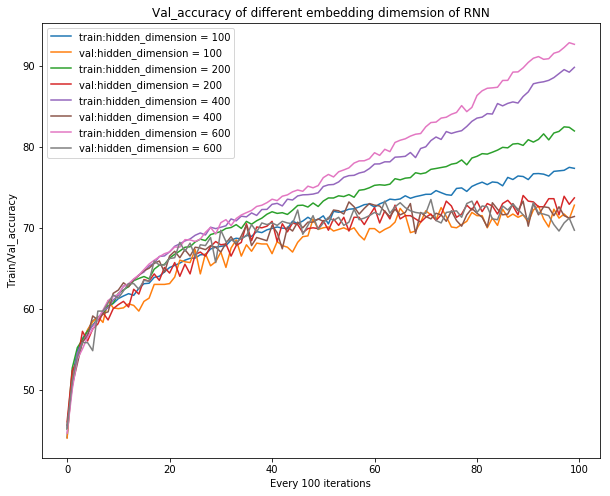

In [78]:
# Plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
i = 0
for a in hidden_dimension_list:
#     theta_hist1, loss_hist1 = batch_grad_descent(X_train, y_train, alpha=a)
    plt.plot(hidden_train_accuracy_list[i], label='train:hidden_dimension = %r' %a)
    plt.plot(hidden_val_accuracy_list[i], label='val:hidden_dimension = %r' %a)
    print("Max_val_acc is {},Mean_val_acc is {}"
          .format(max(hidden_val_accuracy_list[i]),np.mean(hidden_val_accuracy_list[i][20:])))
    i+=1
ax.set_xlabel('Every 100 iterations')
ax.set_ylabel('Train/Val_accuracy')
plt.title('Val_accuracy of different embedding dimemsion of RNN')
plt.legend(loc='best')
plt.show()

### Experiment with diferent ways of interacting the two encoded sentences

In [ ]:
interacting_method = ['concat','add','sub','mul']
train_accuracy_list = []
val_accuracy_list = []

for m in interacting_method:  
    model = RNN(emb_size=MAX_Sentence_LENGTH, embedding_dim = 300, 
                hidden_size=200, num_layers=2, num_classes=3,method = m).to(device)
    learning_rate = 3e-4
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    
    eachtrain_accuracy_list = []
    eachval_accuracy_list = []

    for epoch in range(num_epochs):
        for i, (sentence1, sentence2, lengths1, lengths2, labels) in enumerate(train_loader): 
            model.train()
            optimizer.zero_grad()

            # Forward pass
            outputs = model(sentence1.to(device).long(),sentence2.to(device).long(), 
                lengths1.to(device),lengths2.to(device))
            loss = criterion(outputs, labels.to(device))

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 300 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                
                eachtrain_accuracy_list.append(train_acc)
                eachval_accuracy_list.append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
               
    val_accuracy_list.append(eachval_accuracy_list)
    train_accuracy_list.append(eachtrain_accuracy_list)

In [ ]:
#train on HPC, get the accuracy list
pickle.dump(val_accuracy_list, open('rnn_method_val_accuracy_list.pkl', 'wb'))
pickle.dump(train_accuracy_list, open('rnn_method_train_accuracy_list.pkl', 'wb'))

In [57]:
#load accuracy list
method_train_accuracy_list = pkl.load(open('rnn_method_train_accuracy_list.pkl', "rb"))
method_val_accuracy_list = pkl.load(open('rnn_method_val_accuracy_list.pkl', "rb"))

Max_val_acc is 72.8,Mean_val_acc is 70.05
Max_val_acc is 69.3,Mean_val_acc is 65.25125
Max_val_acc is 73.4,Mean_val_acc is 70.44125
Max_val_acc is 73.5,Mean_val_acc is 70.1525


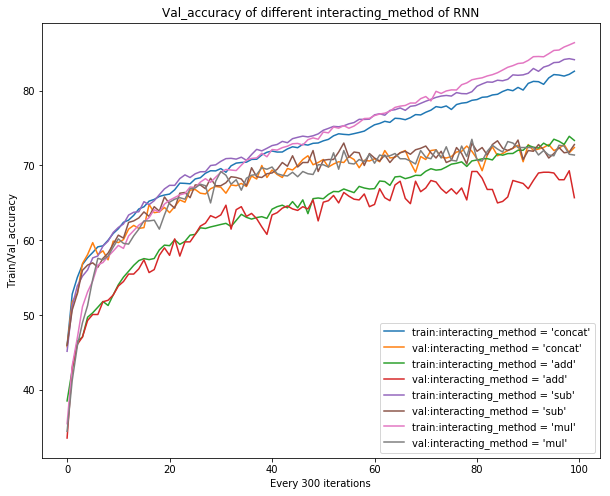

In [69]:
# Plot

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
i = 0
for a in interacting_method:
#     theta_hist1, loss_hist1 = batch_grad_descent(X_train, y_train, alpha=a)
    plt.plot(method_train_accuracy_list[i], label='train:interacting_method = %r' %a)
    print("Max_val_acc is {},Mean_val_acc is {}"
          .format(max(method_val_accuracy_list[i]),np.mean(method_val_accuracy_list[i][20:])))
    plt.plot(method_val_accuracy_list[i], label='val:interacting_method = %r' %a)
    i+=1
ax.set_xlabel('Every 300 iterations')
ax.set_ylabel('Train/Val_accuracy')
plt.title('Val_accuracy of different interacting_method of RNN')
plt.legend(loc='best')
plt.show()

# Convolutional Neural Net model for text

In [30]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes,dropout=0.5,kernel_size=3):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(loaded_embeddings_ft), freeze=True)
        
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size, padding=1)
        self.linear1 = nn.Linear(hidden_size*2, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)
        self.dropout=nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        
    def forward(self, x1, x2, length1, length2):
        batch_size, seq_len1 = x1.size()
        _, seq_len2 = x2.size()
        
        embed1 = self.embedding(x1)
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, hidden1.size(1), hidden1.size(-1))
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, hidden1.size(1), hidden1.size(-1))
        hidden1 = torch.sum(hidden1, dim=1)
        
        embed2 = self.embedding(x2)
        hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, hidden2.size(1), hidden2.size(-1))
        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, hidden2.size(1), hidden2.size(-1))
        hidden2 = torch.sum(hidden2, dim=1)

        hidden = torch.cat((hidden1, hidden2), dim = 1)
        logits = self.relu(self.linear1(hidden))
        logits==self.dropout(logits)
        logits = self.linear2(logits)
        
        return logits

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for sentence1, sentence2, lengths1, lengths2, labels in loader:
        data_batch_1, data_batch_2, lengths_batch_1, lengths_batch_2, label_batch=sentence1, sentence2, lengths1, lengths2, labels
        outputs = F.softmax(model(data_batch_1.to(device).long(), data_batch_2.to(device).long(),
            lengths_batch_1.to(device), lengths_batch_2.to(device)), dim=1) 
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.to(device).view_as(predicted)).sum().item()
    return (100 * correct / total)

### Tuning  hidden dimension in CNN modules 

In [ ]:
hidden_dimension_list = [100, 200, 400, 600]
train_accuracy_list = []
val_accuracy_list = []

for hidden_dimension in hidden_dimension_list: 
    model = CNN(emb_size=300, hidden_size=hidden_dimension, 
                num_classes=3, num_layers =2,dropout=0.5, kernel_size = 3).to(device)

    learning_rate = 3e-4
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    
    eachtrain_accuracy_list = []
    eachval_accuracy_list = []
    
    for epoch in range(num_epochs):
        for i, (sentence1, sentence2, lengths1, lengths2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(sentence1.to(device).long(),sentence2.to(device).long(), 
                lengths1.to(device),lengths2.to(device))
            loss = criterion(outputs, labels.to(device))

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 300 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                
                eachtrain_accuracy_list.append(train_acc)
                eachval_accuracy_list.append(val_acc)
                
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    val_accuracy_list.append(eachval_accuracy_list)
    train_accuracy_list.append(eachtrain_accuracy_list)

In [ ]:
#train on HPC, get the accuracy list
pickle.dump(val_accuracy_list, open('cnn_hidden_val_accuracy_list.pkl', 'wb'))
pickle.dump(train_accuracy_list, open('cnn_hidden_train_accuracy_list.pkl', 'wb'))

In [6]:
#load accuracy list
cnn_hidden_train_accuracy_list = pkl.load(open('cnn_hidden_train_accuracy_list.pkl', "rb"))
cnn_hidden_val_accuracy_list = pkl.load(open('cnn_hidden_val_accuracy_list.pkl', "rb"))

Max_val_acc is 69.6,Mean_val_acc is 67.93875
Max_val_acc is 71.2,Mean_val_acc is 68.85875
Max_val_acc is 71.7,Mean_val_acc is 68.87249999999999
Max_val_acc is 69.9,Mean_val_acc is 67.5325


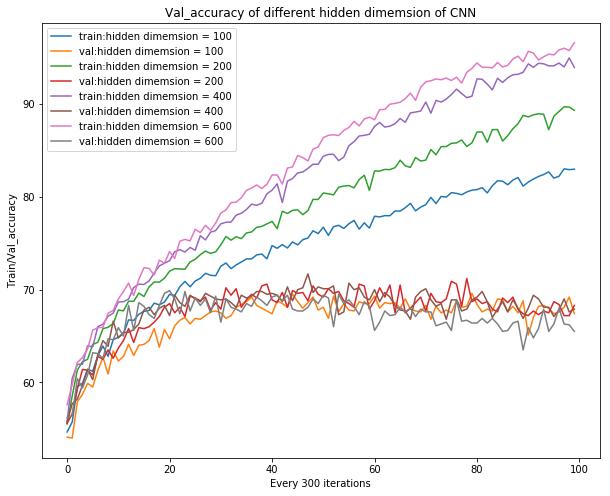

In [70]:
# Plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
i = 0
for a in hidden_dimension_list:
#     theta_hist1, loss_hist1 = batch_grad_descent(X_train, y_train, alpha=a)
    plt.plot(cnn_hidden_train_accuracy_list[i], label='train:hidden dimemsion = %r' %a)
    plt.plot(cnn_hidden_val_accuracy_list[i], label='val:hidden dimemsion = %r' %a)
    print("Max_val_acc is {},Mean_val_acc is {}"
          .format(max(cnn_hidden_val_accuracy_list[i]),np.mean(cnn_hidden_val_accuracy_list[i][20:])))
    i+=1
ax.set_xlabel('Every 300 iterations')
ax.set_ylabel('Train/Val_accuracy')
plt.title('Val_accuracy of different hidden dimemsion of CNN')
plt.legend(loc='best')
plt.show()

### Tuning  kernel size in CNN modules 

In [ ]:
kernel_size_list = [2, 3, 4, 5]
train_accuracy_list = []
val_accuracy_list = []

for kernel in kernel_size_list: 
    model = CNN(emb_size=300, hidden_size=200, 
                num_classes=3, num_layers =2,dropout=0.5,kernel_size=kernel).to(device)

    learning_rate = 3e-4
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    
    eachtrain_accuracy_list = []
    eachval_accuracy_list = []
    
    for epoch in range(num_epochs):
        for i, (sentence1, sentence2, lengths1, lengths2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(sentence1.to(device).long(),sentence2.to(device).long(), 
                lengths1.to(device),lengths2.to(device))
            loss = criterion(outputs, labels.to(device))

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 300 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                
                eachtrain_accuracy_list.append(train_acc)
                eachval_accuracy_list.append(val_acc)
                
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    val_accuracy_list.append(eachval_accuracy_list)
    train_accuracy_list.append(eachtrain_accuracy_list)

In [ ]:
#train on HPC, get the accuracy list
pickle.dump(val_accuracy_list, open('cnn_kernel_val_accuracy_list.pkl', 'wb'))
pickle.dump(train_accuracy_list, open('cnn_kernel_train_accuracy_list.pkl', 'wb'))

In [18]:
#load accuracy list
cnn_kernel_train_accuracy_list = pkl.load(open('cnn_kernel_train_accuracy_list.pkl', "rb"))
cnn_kernel_val_accuracy_list = pkl.load(open('cnn_kernel_val_accuracy_list.pkl', "rb"))

Max_val_acc is 70.8,Mean_val_acc is 68.4425
Max_val_acc is 69.9,Mean_val_acc is 67.49125000000001
Max_val_acc is 70.3,Mean_val_acc is 67.875
Max_val_acc is 69.7,Mean_val_acc is 67.74000000000001


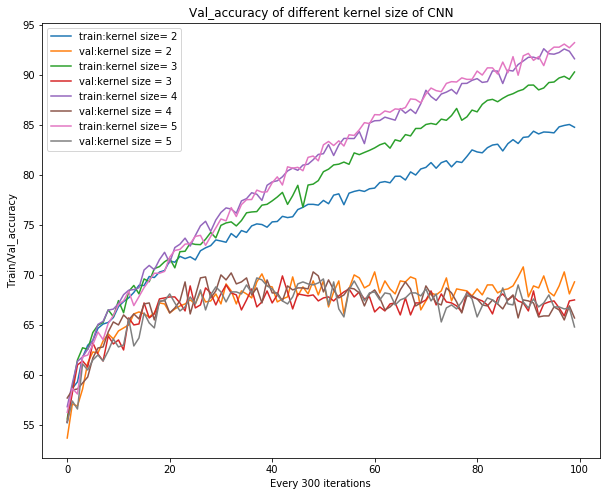

In [71]:
# Plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
i = 0
for a in kernel_size_list:
#     theta_hist1, loss_hist1 = batch_grad_descent(X_train, y_train, alpha=a)
    plt.plot(cnn_kernel_train_accuracy_list[i], label='train:kernel size= %r' %a)
    plt.plot(cnn_kernel_val_accuracy_list[i], label='val:kernel size = %r' %a)
    print("Max_val_acc is {},Mean_val_acc is {}"
          .format(max(cnn_kernel_val_accuracy_list[i]),np.mean(cnn_kernel_val_accuracy_list[i][20:])))
    i+=1
ax.set_xlabel('Every 300 iterations')
ax.set_ylabel('Train/Val_accuracy')
plt.title('Val_accuracy of different kernel size of CNN')
plt.legend(loc='best')
plt.show()

### Tuning  dropout in CNN modules 

In [ ]:
dropout_list = [0, 0.25, 0.5, 0.75]
train_accuracy_list = []
val_accuracy_list = []

for d in dropout_list: 
    model = CNN(emb_size=300, hidden_size=200, 
                num_classes=3, num_layers =2,dropout=d,kernel_size=3).to(device)

    learning_rate = 3e-4
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    
    eachtrain_accuracy_list = []
    eachval_accuracy_list = []
    
    for epoch in range(num_epochs):
        for i, (sentence1, sentence2, lengths1, lengths2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(sentence1.to(device).long(),sentence2.to(device).long(), 
                lengths1.to(device),lengths2.to(device))
            loss = criterion(outputs, labels.to(device))

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 300 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                
                eachtrain_accuracy_list.append(train_acc)
                eachval_accuracy_list.append(val_acc)
                
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    val_accuracy_list.append(eachval_accuracy_list)
    train_accuracy_list.append(eachtrain_accuracy_list)

In [ ]:
#train on HPC, get the accuracy list
pickle.dump(val_accuracy_list, open('cnn_dropout_val_accuracy_list.pkl', 'wb'))
pickle.dump(train_accuracy_list, open('cnn_dropout_train_accuracy_list.pkl', 'wb'))

In [21]:
#load accuracy list
cnn_dropout_train_accuracy_list = pkl.load(open('cnn_dropout_train_accuracy_list.pkl', "rb"))
cnn_dropout_val_accuracy_list = pkl.load(open('cnn_dropout_val_accuracy_list.pkl', "rb"))

Max_val_acc is 70.6,Mean_val_acc is 68.41875
Max_val_acc is 71.2,Mean_val_acc is 67.94000000000001
Max_val_acc is 70.6,Mean_val_acc is 68.39375
Max_val_acc is 70.3,Mean_val_acc is 68.07249999999999


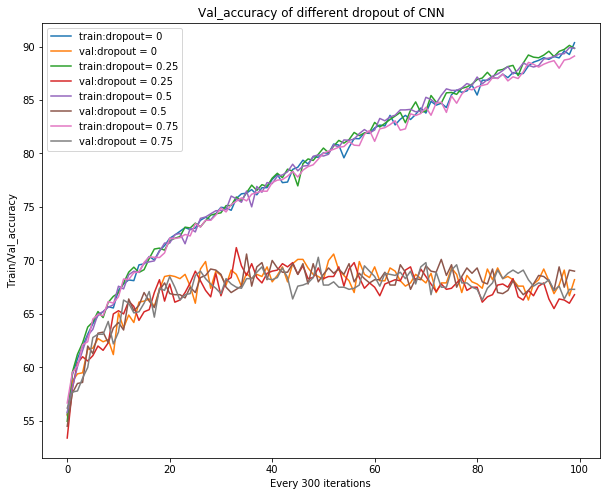

In [72]:
# Plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
i = 0
for a in dropout_list:
#     theta_hist1, loss_hist1 = batch_grad_descent(X_train, y_train, alpha=a)
    plt.plot(cnn_dropout_train_accuracy_list[i], label='train:dropout= %r' %a)
    plt.plot(cnn_dropout_val_accuracy_list[i], label='val:dropout = %r' %a)
    print("Max_val_acc is {},Mean_val_acc is {}"
          .format(max(cnn_dropout_val_accuracy_list[i]),np.mean(cnn_dropout_val_accuracy_list[i][20:])))
    i+=1
ax.set_xlabel('Every 300 iterations')
ax.set_ylabel('Train/Val_accuracy')
plt.title('Val_accuracy of different dropout of CNN')
plt.legend(loc='best')
plt.show()

# Best model parameters and correct and 3 incorrect predictions in the validation set

### BiGru(RNN): Best model parameters - hidden dimemsion = 200, method = 'concat'
### CNN: Best model parameters - hidden dimemsion = 200, kernel size = 2, dropout = 0.5

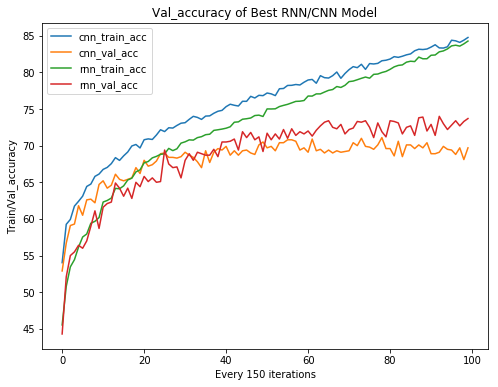

In [124]:
#load accuracy list
cnn_best_train_accuracy_list = pkl.load(open('cnn_best_train_accuracy_list.pkl', "rb"))
cnn_best_val_accuracy_list = pkl.load(open('cnn_best_val_accuracy_list.pkl', "rb"))
rnn_best_train_accuracy_list = pkl.load(open('rnn_best_train_accuracy_list.pkl', "rb"))
rnn_best_val_accuracy_list = pkl.load(open('rnn_best_val_accuracy_list.pkl', "rb"))

# Plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
#     theta_hist1, loss_hist1 = batch_grad_descent(X_train, y_train, alpha=a)
plt.plot(cnn_best_train_accuracy_list[0], label='cnn_train_acc')
plt.plot(cnn_best_val_accuracy_list[0], label='cnn_val_acc')
#     theta_hist1, loss_hist1 = batch_grad_descent(X_train, y_train, alpha=a)
plt.plot(rnn_best_train_accuracy_list[0], label='rnn_train_acc')
plt.plot(rnn_best_val_accuracy_list[0], label='rnn_val_acc')

ax.set_xlabel('Every 150 iterations')
ax.set_ylabel('Train/Val_accuracy')
plt.title('Val_accuracy of Best RNN/CNN Model')
plt.legend(loc='best')
plt.show()

In [125]:
print("Max_val_acc of RNN is {},Mean_val_acc of RNN is {}"
    .format(max(rnn_best_val_accuracy_list[0]),np.mean(rnn_best_val_accuracy_list[0][20:])))
print("Max_val_acc of CNN is {},Mean_val_acc of CNN is {}"
    .format(max(cnn_best_val_accuracy_list[0]),np.mean(cnn_best_val_accuracy_list[0][20:])))

Max_val_acc of RNN is 74.0,Mean_val_acc of RNN is 71.0025
Max_val_acc of CNN is 71.1,Mean_val_acc of CNN is 69.33250000000001


In [93]:
#load saved model from hpc
best_rnn = RNN(emb_size=30, embedding_dim=300, hidden_size=200, num_layers=2, num_classes=3,method='concat')
# run on local, so use cpu instead of gpu
best_rnn.load_state_dict(torch.load('best_rnn',map_location=lambda storage, loc: storage))

In [123]:
i=0 
print('3 Right Predictions')
for data1,data2, length1,length2, labels in val_loader:
    data1_batch,data2_batch, lengths1_batch,lengths2_batch, label_batch = data1,data2, length1,length2, labels 
    outputs = F.softmax(best_rnn(data1_batch.to(device).long(),data2_batch.to(device).long(),lengths1_batch.to(device),lengths2_batch.to(device)), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    for j in range(len(outputs)):
        if predicted[j].eq(labels.to(device)[j].view_as(predicted[j])).sum().item()==1:
            i+=1
            print(' '.join([ordered_words_ft[i] for i in data1_batch[j] if i.item()!=0]))
            print(' '.join([ordered_words_ft[i] for i in data2_batch[j] if i.item()!=0]))
            print('target: ', labels[j].item())
            print('predicted: ', predicted[j].item())
        if i==3:
            break
    if i==3:
        break
i=0 
print()
print('3 Wrong Predictions')

for data1,data2, length1,length2, labels in val_loader:
    data1_batch,data2_batch, lengths1_batch,lengths2_batch, label_batch = data1,data2, length1,length2, labels 
    outputs = F.softmax(best_rnn(data1_batch.to(device).long(),data2_batch.to(device).long(),lengths1_batch.to(device),lengths2_batch.to(device)), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    for j in range(len(outputs)):
        if predicted[j].eq(labels.to(device)[j].view_as(predicted[j])).sum().item()!=1:
            i+=1
            print(' '.join([ordered_words_ft[i] for i in data1_batch[j] if i.item()!=0]))
            print(' '.join([ordered_words_ft[i] for i in data2_batch[j] if i.item()!=0]))
            print('target: ', labels[j].item())
            print('predicted: ', predicted[j].item())
        if i==3:
            break
    if i==3:
        break

3 Right Predictions
Two men standing near a metal structure in front of a brick wall .
Men stand in line at a water fountain in front of a brick building .
target:  2
predicted:  2
two girls sitting by a tree while playing .
The girls are not near a tree .
target:  1
predicted:  1
A man talks on his cellphone in private .
A man is on his cellphone .
target:  0
predicted:  0

3 Wrong Predictions
A young man wearing goggles , is jumping out of a pool , splashing water everywhere .
An old man jumping into a pool .
target:  1
predicted:  0
A building that portrays beautiful architecture stands in the sunlight as somebody on a bike passes by .
A <unk> rides past an abandoned warehouse on a rainy day
target:  2
predicted:  1
An old dusty car is half way in the brown water .
Someone wrecked their car a long time ago .
target:  2
predicted:  1


# Evaluating on MultiNLI

In [85]:
### Function that preprocessed dataset
def read_mnlidata(df):
    dataset = []  
    for index, row in df.iterrows():
        if row['label'] == 'entailment':
            label = 0
        elif row['label'] == 'contradiction':
            label = 1
        else:
            label = 2
        dataset.append(([token for token in row['sentence1'].split()], 
                        [token for token in row['sentence2'].split()], 
                        label))      
    return dataset

filepath = './hw2_data'
mnli_val_path = filepath + "/mnli_val.tsv"
mnli_val_df = pd.read_csv(mnli_val_path, sep='\t', header=0)

### BiGru(RNN)

In [106]:
#load saved model from hpc
best_rnn = RNN(emb_size=30, embedding_dim=300, hidden_size=200, num_layers=2, num_classes=3,method='concat')
# run on local, so use cpu instead of gpu
best_rnn.load_state_dict(torch.load('best_rnn',map_location=lambda storage, loc: storage))
print('RNN for MNLI')
for gen in set(mnli_val_df.genre):  
    mnli_val =mnli_val_df[mnli_val_df.genre==gen].reset_index()
    mnli_val_tokens = read_mnlidata(mnli_val)
    mnli_val_data = token2index_dataset(mnli_val_tokens)
    mnli_val_dataset = VocabDataset(mnli_val_data)
    mnli_val_loader = torch.utils.data.DataLoader(dataset=mnli_val_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=vocab_collate_func,
                                               shuffle=False)
    test_acc = test_model(mnli_val_loader, best_rnn)
    print(gen,test_acc)

RNN for MNLI
travel 46.23217922606925
government 52.75590551181102
slate 47.90419161676647
telephone 50.049751243781095
fiction 48.24120603015076


### CNN

In [104]:
#load saved model from hpc
best_cnn = CNN(emb_size=300, hidden_size=200, num_layers=2, num_classes=3,dropout=0.5,kernel_size=2)
# run on local, so use cpu instead of gpu
best_cnn.load_state_dict(torch.load('best_cnn',map_location=lambda storage, loc: storage))

print('CNN for MNLI')
for gen in set(mnli_val_df.genre):  
    best_cnn.eval()
    mnli_val =mnli_val_df[mnli_val_df.genre==gen].reset_index()
    mnli_val_tokens = read_mnlidata(mnli_val)
    mnli_val_data = token2index_dataset(mnli_val_tokens)
    mnli_val_dataset = VocabDataset(mnli_val_data)
    mnli_val_loader = torch.utils.data.DataLoader(dataset=mnli_val_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=vocab_collate_func,
                                               shuffle=False)
    test_acc = test_model(mnli_val_loader, best_cnn)
    
    print(gen,test_acc)

CNN for MNLI
travel 46.537678207739305
government 47.73622047244095
slate 45.808383233532936
telephone 49.15422885572139
fiction 45.82914572864322
